🚀 Starting robust validation for TIC 231728511...
1. Downloading apertures for each sector...
   -> Sector 4: OK (10 pixels)
   -> Sector 5: OK (12 pixels)
   -> Sector 6: OK (13 pixels)


C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


   -> Sector 27: OK (12 pixels)
   -> Sector 31: OK (11 pixels)
   -> Sector 32: OK (11 pixels)
   -> Sector 33: OK (10 pixels)
   -> Sector 37: OK (10 pixels)
   -> Sector 64: OK (12 pixels)
   -> Sector 67: OK (10 pixels)
   -> Sector 87: OK (11 pixels)
   -> Sector 94: OK (10 pixels)
2. Initializing Triceratops target instance...
3. Calculating neighbor depths using extracted apertures...
4. Calculating Final FPP...
griz mags: nan nan nan nan


C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:377: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = read_csv(output_url, delim_whitespace=True)
C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:377: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = read_csv(output_url, delim_whitespace=True)


Calculating TP scenario probability for 231728511.
Calculating EB and EBx2P scenario probabilities for 231728511.
Z, Teff, logg: 0.0 3500 5.0
Calculating PTP scenario probability for 231728511.
Calculating PEB and PEBx2P scenario probabilities for 231728511.
Calculating STP scenario probability for 231728511.
Calculating SEB and SEBx2P scenario probabilities for 231728511.
Calculating DTP scenario probability for 231728511.


C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:400: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = read_csv(trilegal_fname)[:-2]


Calculating DEB and DEBx2P scenario probabilities for 231728511.


C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:400: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = read_csv(trilegal_fname)[:-2]


Calculating BTP scenario probability for 231728511.


C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:400: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = read_csv(trilegal_fname)[:-2]


Calculating BEB and BEBx2P scenario probabilities for 231728511.


C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:400: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = read_csv(trilegal_fname)[:-2]
C:\Users\Usuari\anaconda3\envs\triceratops_plus\lib\site-packages\triceratops\funcs.py:186: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)


griz mags: nan nan nan nan
Calculating NTP, NEB, and NEB2xP scenario probabilities for 734626130.
Z, Teff, logg: 0.0 5750 4.5
griz mags: nan nan nan nan
Calculating NTP, NEB, and NEB2xP scenario probabilities for 734626114.
Z, Teff, logg: 0.0 4500 4.5
griz mags: nan nan nan nan
Calculating NTP, NEB, and NEB2xP scenario probabilities for 231728519.
Z, Teff, logg: 0.0 5250 4.5
griz mags: nan nan nan nan
Calculating NTP, NEB, and NEB2xP scenario probabilities for 231728505.
Z, Teff, logg: 0.0 6000 4.5
------------------------------
Final FPP  (False Positive Prob)        = 0.250895
Final NFPP (Nearby False Positive Prob) = 0.000072
------------------------------


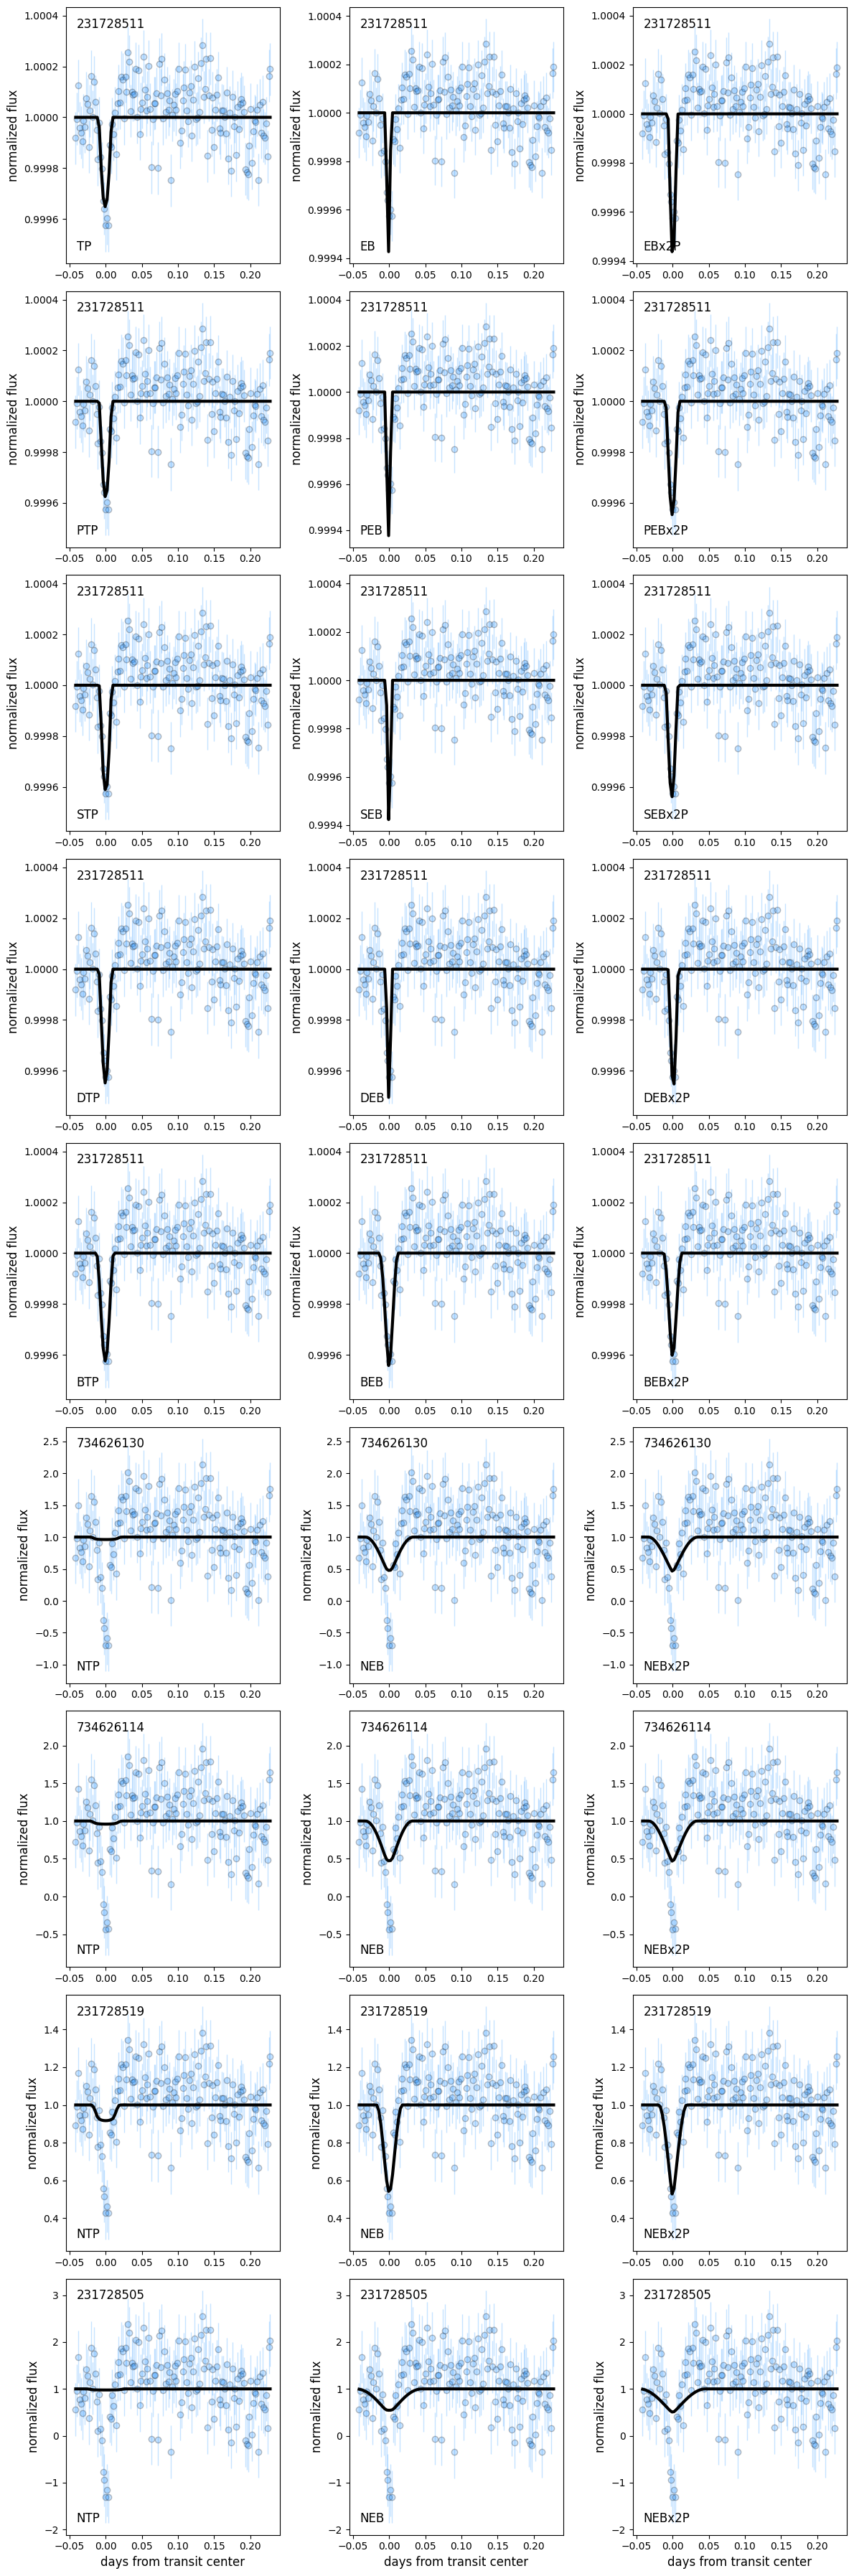

In [ ]:
"""
03_triceratops_vetting.ipynb

Description:
    This script performs a statistical validation of the planet candidate 
    TIC 231728511 (TOI 864.01) using the 'triceratops' library.
    
    The workflow includes:
    1. Downloading Target Pixel Files (TPFs) from the SPOC pipeline.
    2. Extracting the precise pixel apertures used for each sector.
    3. Calculating the False Positive Probability (FPP) and Nearby False 
       Positive Probability (NFPP) based on the folded light curve.

Author: Biel Escolà Rodrigo
Target: TIC 231728511
"""

import pandas as pd
import numpy as np
import lightkurve as lk
import triceratops.triceratops as tr
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
TARGET_ID = 231728511
ORBITAL_PERIOD = 0.52067  # Days
TRANSIT_DEPTH = 0.000158   # Dimensionless (Flux fraction)

# List of TESS sectors to be analyzed
SECTORS_LIST = [4, 5, 6, 27, 31, 32, 33, 37, 64, 67, 87, 94]

print(f"🚀 Starting robust validation for TIC {TARGET_ID}...")

# --- 2. APERTURE EXTRACTION ---
# We must extract the exact pixel apertures used by the SPOC pipeline 
# to ensure the contamination analysis matches the light curve data.
print("1. Downloading apertures for each sector...")

apertures = []
valid_sectors = [] # List to store only sectors that are successfully downloaded

for s in SECTORS_LIST:
    try:
        # Download the Target Pixel File (TPF) for the specific sector
        search = lk.search_targetpixelfile(f"TIC {TARGET_ID}", sector=s, author="SPOC")
        
        if len(search) > 0:
            tpf = search.download()
            
            # Extract the pipeline mask (pixels used to calculate flux)
            mask = tpf.pipeline_mask
            
            # Convert mask to pixel coordinates (Column, Row)
            # This aligns the aperture with the pixels in the TPF
            ap_pixel_coords = np.c_[tpf.column + np.where(mask)[1], tpf.row + np.where(mask)[0]]
            
            apertures.append(ap_pixel_coords)
            valid_sectors.append(s)
            print(f"   -> Sector {s}: OK ({len(ap_pixel_coords)} pixels)")
            
        else:
            print(f"   -> Sector {s}: Not found (Skipping)")
            
    except Exception as e:
        print(f"   ⚠️ Error processing Sector {s}: {e}")

# Update the main list to only include valid sectors to prevent mismatches
SECTORS_LIST = valid_sectors

# --- 3. INITIALIZATION ---
print("2. Initializing Triceratops target instance...")
# Initialize the target object using the validated list of sectors
target = tr.target(ID=TARGET_ID, sectors=np.array(SECTORS_LIST))

# --- 4. NEIGHBOR DEPTH CALCULATION ---
print("3. Calculating neighbor depths using extracted apertures...")
# Calculate the transit depth required for nearby stars to mimic the signal,
# based on the specific pixel apertures we extracted.
target.calc_depths(tdepth=TRANSIT_DEPTH, all_ap_pixels=apertures)

# --- 5. PROBABILITY CALCULATION (FPP/NFPP) ---
print("4. Calculating Final FPP...")

CSV_FILENAME = "TOI864_01_ALL_SECTORS_FOLDED.csv"

try:
    # Load the phase-folded light curve data generated in previous steps
    # Structure assumed: [Phase/Time, Flux, Flux Error]
    df = pd.read_csv(CSV_FILENAME, header=None)
    
    # Extract arrays. 
    # Note: A phase offset (+0.093) is applied to center the transit if necessary.
    time_vals = df[0].values + 0.093 
    flux_vals = df[1].values
    err_vals = df[2].values
    
    # Run the core probability calculation
    target.calc_probs(
        time=time_vals,
        flux_0=flux_vals,
        flux_err_0=np.mean(err_vals), # Use mean error for efficiency
        P_orb=ORBITAL_PERIOD,
        parallel=True # Enable parallel processing for speed
    )

    # --- RESULTS ---
    print("-" * 30)
    print(f"Final FPP  (False Positive Prob)        = {target.FPP:.6f}")
    print(f"Final NFPP (Nearby False Positive Prob) = {target.NFPP:.6f}")
    print("-" * 30)

    # Visualizing the fits for different scenarios
    target.plot_fits(time=time_vals, flux_0=flux_vals, flux_err_0=np.mean(err_vals))
    plt.show()

except FileNotFoundError:
    print(f"❌ ERROR: Could not find the file '{CSV_FILENAME}'.")
    print("   Please ensure the CSV generation script has been run successfully.")